# Programming Exercise 3: Multi-class Classification and Neural Networks
In this exercise, you will implement one-vs-all logistic regression and neural
networks to recognize hand-written digits.

In [1]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 Multi-class Classification
For this exercise, you will use logistic regression and neural networks to
recognize hand-written digits (form 0 to 9). Automated hand-written digit
recognition is widely used today - from recognizing zip codes (postal codes) on
mail envelopes to recognizing amounts written on bank checks. This exercise
show you how the methods you have learned can be used for this classification
task.

In the first of the exercise, you will extend your previous implementation of
logistic regression and apply it to one-vs-all classification.

### 1.1 Dataset
You are given a data set in `ex3data1.mat` that contains 5000 training examples
of handwritten digits . The `.mat`

There are 5000 training examples in `ex3data1.mat` (this is a subset of the
[MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digit dataset), where
each training example is a 20 pixel by 20 pixel grayscale image of the digit.
Each pixel is represented by a floating point number indicating the grayscale
intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a
400-dimensional vector. Each of these training examples becomes a single row
in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row
is a training example for a handwritten digit image.

\begin{equation}
X=\left[\begin{array}{c}
-\left(x^{(1)}\right)^{T}- \\
-\left(x^{(2)}\right)^{T}- \\
\vdots \\
-\left(x^{(m)}\right)^{T}-
\end{array}\right]
\end{equation}

The second part of the training set is a 5000-dimensional vector $y$ that
contains labels for the training set. We start the exercise by first loading
the dataset. Execute the cell below, you do not need to write any code here.

In [2]:
# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

# Loading data
data = loadmat('ex3data1.mat')

# training data stored in arrays X, y
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
y[y == 10] = 0

m = y.size

### 1.2 Visualizing the data
You will begin by visualizing a subset of the training set. In the following
cell, the code randomly selects 100 rows from $X$ and passes those rows to the
`displayData` function. This function maps each row to a 20 pixel by 20 pixel
grayscale image and displays the images together.

In [3]:
def displayData(X, figsize=(8, 8)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        m, n = 1, X.size
        X = X[None] # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_size = int(np.round(np.sqrt(n)))

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, axes = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    axes = [axes] if m == 1 else axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(X[i].reshape(example_size, example_size, order='F'),
                  cmap='binary', extent=[0, 1, 0, 1])
        ax.axis('off')

Run the following cell to visualize the data.

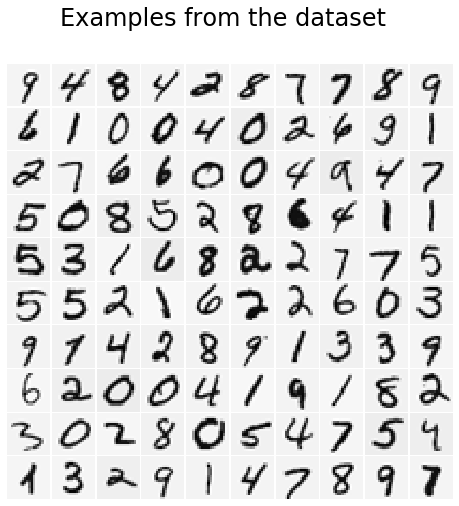

In [4]:
# Randomly select 100 data points to display
X_random = X[np.random.choice(m, 100), :]
displayData(X_random)
plt.suptitle('Examples from the dataset', fontsize=24);

### 1.3 Vectorizing Logistic Regression
You will be using multiple one-vs-all logistic regression models to build a
multi-class classifier. Since there are 10 classes, you will need to train 10
separate logistic regression classifier. To make this training efficient, it is
important to ensure that your code is well vectorized. In this section, you
will implement a vectorized version of logistic regression that does not employ
any `for` loops. You can use your code in the previous exercise as a starting
point for this exercise.

To test your vectorized logistic regression, we will use custom data in the
following cell.

In [5]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.c_[np.ones([5, 1]), np.arange(1, 16).reshape(5, 3, order='F') / 10.0]

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test values for the regularization parameter
lambda_t = 3

#### 1.3.1 Vectorizing the cost function
We will begin by writing a vectorized version of the cost function. Recall that
in (unregularized) logistic regression, the cost function is

\begin{equation}
J(\theta)=\frac{1}{m} \sum_{i=1}^{m}\left[-y^{(i)} \log \left(h_{\theta}\left(x^{(i)}\right)\right)-\left(1-y^{(i)}\right) \log \left(1-h_{\theta}\left(x^{(i)}\right)\right)\right].
\end{equation}

To compute each element in the summation, we have to compute
$h_{\theta}\left(x^{(i)}\right)$ for every example $i$, where
$h_{\theta}\left(x^{(i)}\right) = g\left( \theta^T x^{(i)} \right)$ and
$g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can
compute this quickly for all our examples by using matrix multiplication.

Let us define $X$ and $\theta$ as

\begin{equation}
X=\left[\begin{array}{c}
-\left(x^{(1)}\right)^{T}- \\
-\left(x^{(2)}\right)^{T}- \\
\vdots \\
-\left(x^{(m)}\right)^{T}-
\end{array}\right] \quad \text{ and } \quad \theta=
\left[\begin{array}{c}
\theta_{0} \\
\theta_{1} \\
\vdots \\
\theta_{n}
\end{array}\right].
\end{equation}

Then, by computing the matrix product $X\theta$, we have

\begin{equation}
X \theta=
\left[\begin{array}{c}
-\left(x^{(1)}\right)^{T} \theta- \\
-\left(x^{(2)}\right)^{T} \theta- \\
\vdots \\
-\left(x^{(m)}\right)^{T} \theta-
\end{array}\right]=
\left[\begin{array}{c}
-\theta^{T}\left(x^{(1)}\right)- \\
-\theta^{T}\left(x^{(2)}\right)- \\
\vdots \\
-\theta^{T}\left(x^{(m)}\right)-
\end{array}\right].
\end{equation}

In the last equality, we used the fact that $a^Tb = b^Ta$ if $a$ and $b$ are
vectors. This allows us to compute the products $\theta^Tx^{(i)}$ for all our
examples $i$ in one line of code.

#### 1.3.2 Vectorizing the gradient
Recall that the gradient of the (unregularized) logistic regression cost is a
vector where the $j^{\text{th}}$ element is defined as

\begin{equation}
\frac{\partial J}{\partial \theta_{j}}=\frac{1}{m} \sum_{i=1}^{m}\left(\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x_{j}^{(i)}\right)
\end{equation}

To vectorize this operation over the dataset, we start by writing out all the
partial derivatives explicitly for all $\theta_j$,

$$\begin{align*} \begin{bmatrix} \frac{\partial J}{\partial \theta_{0}} \\ \frac{\partial J}{\partial \theta_{1}} \\ \frac{\partial J}{\partial \theta_{2}} \\ \vdots \\ \frac{\partial J}{\partial \theta_{n}} \end{bmatrix}  & = \frac{1}{m} \left[\begin{array}{c} \sum_{i=1}^{m}\left(\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x_{0}^{(i)}\right) \\ \sum_{i=1}^{m}\left(\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x_{1}^{(i)}\right) \\ \sum_{i=1}^{m}\left(\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x_{2}^{(i)}\right) \\ \vdots \\ \sum_{i=1}^{m}\left(\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x_{n}^{(i)}\right) \end{array}\right] \\ & =  \frac{1}{m} \sum_{i=1}^{m}\left(\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x^{(i)}\right) \\  & = \frac{1}{m}X^{T}\left(h_{\theta}(x)-y\right). \end{align*}$$

Where

\begin{equation}
h_{\theta}(x)-y=\left[\begin{array}{c}
h_{\theta}\left(x^{(1)}\right)-y^{(1)} \\
h_{\theta}\left(x^{(2)}\right)-y^{(2)} \\
\vdots \\
h_{\theta}\left(x^{(1)}\right)-y^{(m)}
\end{array}\right]
\end{equation}

Note that $x^{(i)}$ is a vector, while $h_{\theta}\left(x^{(i)}\right) - y^{(i)}$
is a scalar (single number). To understand the last step of the derivation, let
$\beta_i= \left(h_{\theta}\left( x^{(i)} \right) - y^{(i)} \right)$ and observe
that:

$$\sum_{i} \beta_{i} x^{(i)}=\left[\begin{array}{cccc} | & | & & | \\ x^{(1)} & x^{(2)} & \dots & x^{(m)} \\ | & | & & | \end{array}\right]\left[\begin{array}{c} \beta_{1} \\ \beta_{2} \\ \vdots \\ \beta_{m} \end{array}\right]=X^{T} \beta $$

Where the values $\beta_i= \left(h_{\theta}\left( x^{(i)} \right) - y^{(i)} \right)$.

The expression above allows us to compute all the partial derivatives without
any loops. If you are comfortable with linear algebra, we encourage you to work
through the matrix multiplications above to convince yourself that the vectorized
version does the same computations.

Your job is to write the unregularized cost function `lrCostFunction` which
returns both the cost function $J(\theta)$ and its gradient
$\frac{\partial J}{\partial \theta}. A fully vectorized version of
`lrCostFunction` should not contain any loops.

In [6]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.
    """
    g = 1 / (1 + np.exp(-z))
    return g

def lrCostFunction(theta, X, y, lambda_):
    """
    Computes the cost of using theta as the parameter for regularized logistic
    regression and the gradient of the cost w.r.t. to the parameters.

    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is
        the number of features including any intercept.

    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (including intercept).

    y : array_like
        The data labels. A vector with shape (m, ).

    lambda_ : float
        The regularization parameter.

    Returns
    -------
    cost : float
        The computed value for the regularized cost function.

    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    """
    # Initialize some useful values
    m = y.size

    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)

    h = sigmoid(np.dot(X, theta.T))
    cost = - np.sum(y * np.log(h) + (1 - y) * np.log(1 - h)) / m + \
           0.5 * lambda_ * np.dot(theta[1:].T, theta[1:]) / m
    grad = np.dot(X.T, h - y) / m
    grad[1:] += (lambda_ * theta / m)[1:]

    return cost, grad

1.3.3 Vectorizing regularized logistic regression
After you have implemented vectorization for logistic regression, you will now add
regularization to the cost function. Recall that for regularized logistic
regression, the cost function is defined as

\begin{equation}
J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log(h_\theta(x^{(i)})) -
 (1 - y^{(i)})\log(1 - h_\theta(x^{(i)})) \right] + \frac{\lambda}{2m}
 \sum_{j=1}^n \theta^2_j.
\end{equation}

Note that you should *not* be regularizing $\theta_0$ which is used for the
bias term.

Correspondingly, the partial derivative of regularized logistic regression cost
for $\theta_j$ is defined as

$$ \begin{array}{ll} \frac{\partial J(\theta)}{\partial \theta_{0}}=\frac{1}{m} \sum_{i=1}^{m}\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x_{j}^{(i)} & \text { for } j=0 \\ \frac{\partial J(\theta)}{\partial \theta_{j}}=\left(\frac{1}{m} \sum_{i=1}^{m}\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x_{j}^{(i)}\right)+\frac{\lambda}{m} \theta_{j} & \text { for } j \geq 1 \end{array}$$

Now modify your code in `lrCostFunction` in the previous cell to account for
regularization. Once again, you should not put any loops into your code.

Once you finished your implementation, you can call the function
`lrCostFunction` to test your solution usign the following cell:

In [7]:
cost, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(cost))
print('Expected cost: 2.534819\n')
print('Gradients         : [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients: [0.146561, -0.548558, 0.724722, 1.398003]')

Cost         : 2.534819
Expected cost: 2.534819

Gradients         : [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients: [0.146561, -0.548558, 0.724722, 1.398003]


### 1.4 One-vs-all Classification
In this part of the exercise, you will implement one-vs-all classification by
training multiple regularized logistic regression classifier, one for each of
the $K$ classes in our dataset. In the handwritten digits dataset, $K = 10$,
but your code should work for any value of $K$.

You should now complete the code for the function `oneVsAll` below, to train
one classifier for each class. In particular, your code should return all the
classifier parameters in a matrix $\theta \in \Bbb{R}^{K \times (N + 1)}$,
where each row of $\theta$ corresponds to the learned logistic regression
parameters for one class. You can do this with a "for"-loop from 0 to $K - 1$,
training each classifier independently.

Note that the $y$ argument to this function is a vector of labels from 0 to 9.
When training the classifier for class $k \in \lbrace 0, \dots, K - 1 \rbrace$,
you will want a $K$-dimensional vector of labels $y$, where $y_i \in \{ 0, 1 \}$
indicates whether the $j^{\text{th}}$ training instance belongs to class $k$
($y_j == 1$), or if it belongs to a different class ($y_j == 0$). You may find
logical arrays helpful for this task.

Futhermore, you will be using scipy's `optimize.minimize` for this exercise.

In [8]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.

    Parameters
    ----------
    X : array_like
        The input dataset of shape (m, n). m is the number of data points,
        and n is the number of features. Note that we do not assume that the
        intercept term (or bias) is in X, however we provide the code below
        to add the bias term to X.

    y : array_like
        The data labels. A vector of shape (m, ).

    num_labels : int
        Number of possible labels.

    lambda_ : float
        The logistic regularization parameter.

    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K, n+1) where K is number of classes
        (ie. `num_labels`) and n is number of features without the bias.
    """
    # Some useful variables
    m, n = X.shape

    # You need to return the following variables correctly
    all_theta = np.zeros([num_labels, n + 1])

    # Add ones to the X data matrix
    X = np.c_[np.ones([m, 1]), X]

    for i in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(fun=lrCostFunction,
                                x0=initial_theta,
                                args=(X, (y == i), lambda_),
                                jac=True,
                                method='CG',
                                options=options)
        all_theta[i] = res.x

    return all_theta

After you have completed the code for `oneVsAll`, the following cell will use
your implementation to train a multi-class classifier.

In [9]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

#### 1.4.1 One-vs-all Prediction
After training your one-vs-all classifier, you can now use it to predict the
digit contained in a given image. For each input, you should compute the
"probability" that it belongs to each class using the trained logistic
regression classifiers. Your one-vs-all prediction function will pick the class
for which the corresponding logistic regression classifier outputs the highest
probability and return the class label ($0, 1, \dots, K-1$) as the prediction
for the input example. You should now complete the code in the function
`predictOneVsAll` to use the one-vs-all classifier for making predictions.

In [10]:
def predictOneVsAll(all_theta, X):
    """
    Return a vector of predictions for each example in the matrix X.

    Parameters
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.

    X : array_like
        Data points to predict their labels. This is a matrix of shape (m, n)
        where m is number of data points to predict, and n is number of
        features without the bias term. Note we add the bias term for X in
        this function.

    Returns
    -------
    p : array_like
        The predictions for each data point in X.
        This is a vector of shape (m, ).
    """
    m = X.shape[0]
    X = np.c_[np.ones([m, 1]), X]
    p = np.argmax(sigmoid(np.dot(X, all_theta.T)), axis=1)

    return p

Now call this function using the learned values of $\theta$. You should see
that the training set accuracy is about 95.1% (i.e., it classifies 95.1% of the
examples in the training set correctly).

In [11]:
predict = predictOneVsAll(all_theta, X)
print('Training set accuracy: {:.2f}%'.format(np.mean(predict == y) * 100))

Training set accuracy: 95.12%


## 2 Neural Networks
In the previous part of this exercise, you implemented multi-class logistic
regression to recognize handwritten digits. However, logistic regression cannot
form more complex hypotheses as it is only a linear classifier (you could add
more features - such as polynomial features - to logistic regression, but that
can be very expensive to train).

In this part of the exercise, you will implement a neural network to recognize
handwritten digits using the same training set as before. The neural network
will be able to represent complex models that form non-linear hypotheses. You
will be using parameters from a neural network that we have already trained.
Your goal is to implement the feedforward propagation algorithm to use our
weights for prediction.

We start by first loading and visualizing the dataset which contains the MNIST
handwritten digits (this is same as we did in the first part of this exercise,
we reload it here to ensure the variables have not been modifies).

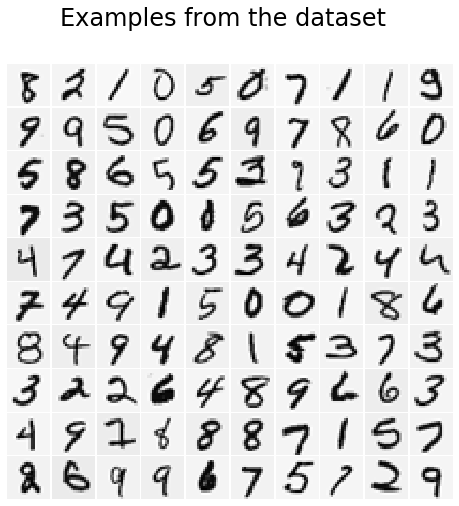

In [12]:
data = loadmat('ex3data1.mat')
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
y[y == 10] = 0

# get number of examples in dataset
m = y.size

# Randomly select 100 data points to display
X_random = X[np.random.choice(m, 100), :]
displayData(X_random)
plt.suptitle('Examples from the dataset', fontsize=24);

### 2.1 Model representation
Our neural network is shown in the following figure.

![NkuVmQ.png](https://s1.ax1x.com/2020/06/16/NkuVmQ.png)

It has 3 layers: an input layer, a hidden layer and an output layer. Recall
that our inputs are pixel values of digit images. Since images are of size
$20 \times 20$, this gives us 400 input layer units (excluding the extra bias
unit which always outputs +1). As before, the training data will be loaded into
the variables $X$ and $y$.

You have been provided with a set of network parameters $(\Theta^{(1)},\Theta^{(2)})$
already trained by us. These are stored in `ex3weights.mat`. The following cell
loads those parameters into `Theta1` and `Theta2`. The parameters have
dimensions that are sized for a neural network with 25 units in the second
layer and 10 output units (corresponding to the 10 digit classes).

In [13]:
# Setup the parameters you will use for this exercise
input_layer_size = 400      # 20x20 input images of digits
hidden_layer_size = 25      # 25 hidden units
num_labels = 10             # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary
weights = loadmat('ex3weights.mat')

# Get the model weights from the dictionary
# Theta1 has size 25 x 401, Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

### 2.2 Feedforward Propagation and Prediction
Now you will implement feedforward propagation for the neural network. You will
need to complete the code in the function `predict` to return the neural
network's prediction. You should implement the feedforward computation that
computes $h_\theta(x^{(i)})$ for every example $i$ and returns the associated
predictions. Similar to the one-vs-all classification strategy, the prediction
from the neural network will be the label that has the largest output
$(h_\theta(x))_k$.

In [14]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network.

    Parameters
    ----------
    Theta1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)

    Theta2: array_like
        Weights for the second layer in the neural network.
        It has shape (output layer size x 2nd hidden layer size)

    X : array_like
        The image inputs having shape (number of examples x image dimensions).

    Return
    ------
    p : array_like
        Predictions vector containing the predicted label for each example.
        It has a length equal to the number of examples.
    """
    a1 = np.c_[np.ones([X.shape[0], 1]), X]
    z2 = np.dot(a1, Theta1.T)
    a2 = np.c_[np.ones([z2.shape[0], 1]), sigmoid(z2)]
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)

    p = np.argmax(a3, axis=1) + 1
    p[p == 10] = 0

    return p

Once you are done, call your predict function using the loaded set of parameters
for `Theta1` and `Theta2`. You should see that the accuracy is about 97.5%.

In [15]:
pred = predict(Theta1, Theta2, X)
print('Training set accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training set accuracy: 97.52%


After that, we will display images from the training set one at a time, while
at the same time printing out the predicted label for the displayed image.

Neural network prediction: 6


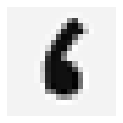

In [16]:
X_predict = X[np.random.choice(m, 1)]
displayData(X_predict, figsize=(2, 2))
print('Neural network prediction: {}'.format(*predict(Theta1, Theta2, X_predict)))